In [1]:
import os
import sys
from collections import OrderedDict, defaultdict

import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec
from scipy import stats
from scipy.io import mmread, mmwrite
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize, scale

# from synchromesh.scripts.utils import read_str_list, sanitize_mtx, norm, do_pf, do_log_pf
# from synchromesh.scripts.plot import  plot_depth_norm, plot_depth_dist, plot_knee, plot_pc_depth, plot_mean_var, plot_monotone, plot_example_gene


def nd(arr):
    return np.asarray(arr).reshape(-1)


def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)
    ax.set_aspect("equal")
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax


fsize = 15

base_figure_path = "figures"


alpha = 0.33

import matplotlib

matplotlib.rcParams["mathtext.fontset"] = "cm"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["font.size"] = fsize
%config InlineBackend.figure_format = 'retina'

In [2]:
cividis = matplotlib.cm.get_cmap("cividis")
colors = {"cell": cividis(0.01), "gene": cividis(0.5), "mono": cividis(0.99)}

In [3]:
def plot_meanvar(mtx, raw_mean, minlim=1e-4, maxlim=1e5, ax=None):
    p = {
        "xlabel": "Gene mean",
        "ylabel": "Gene variance",
        "xscale": "log",
        "yscale": "log",
        "xlim": (minlim, maxlim),
    }

    gvar = np.var(mtx, axis=0)
    gcov = np.sqrt(np.var(gvar)) / np.mean(gvar)

    y = np.var(mtx, axis=0)
    yy = (y - y.mean()) / np.sqrt(np.var(y))

    ax.scatter(
        raw_mean,
        y,
        facecolor=colors["gene"],
        alpha=alpha,
        edgecolor="k",
        label=f"CoV: {gcov:,.1f}",
    )
    ax.legend(prop={"size": 12})
    ax.set(**p)
    yex(ax)
    return ax


def plot_depth(mtx, raw_cell_counts, ax):
    x = raw_cell_counts
    y = np.sum(mtx, axis=1)

    minx, maxx = min(x), max(x)
    miny, maxy = min(y), max(y)
    maxy = maxy - miny

    xx = (x - minx) / maxx
    yy = (y - miny) / maxy

    close = np.all(np.allclose(y, y[0]))
    if close:
        yy = [1] * len(y)
    ax.scatter(xx, yy, edgecolor="k", facecolor=colors["cell"], alpha=alpha)

    reg = LinearRegression().fit(xx.reshape(-1, 1), yy)
    r2 = reg.score(xx.reshape(-1, 1), yy)

    if close:
        # handle the degenerate case where the slope is 0 since all values y are same
        r2 = 0

    xxx = np.array([min(xx), max(xx)])

    ax.plot(
        xxx,
        reg.coef_ * xxx + reg.intercept_,
        color="darkgray",
        linestyle="--",
        label=f"r$^2$: {r2:,.2f}",
        linewidth=3,
    )

    p = {
        "xlabel": "Raw cell count",
        "ylabel": "Transform cell count",
        "xlim": (-0.1, 1.1),
        "ylim": (-0.1, 1.1),
    }
    ax.set(**p)
    ax.legend(prop={"size": 12})
    return ax


def plot_mono(matrix, raw, ax):
    x = mono(matrix, raw)
    p = {"xlabel": "Spearman r", "ylabel": "Frequency", "xlim": (-1.2, 1.2)}
    close = np.all(np.allclose(x, x[0]))
    if close:
        weights = np.ones(len(x)) / len(x)
        x = np.array([1] * len(x))
        ax.hist(x, facecolor=colors["mono"], edgecolor="k", weights=weights)
    else:
        weights = np.ones(len(x)) / len(x)
        ax.hist(x, facecolor=colors["mono"], weights=weights, edgecolor="k")
    ax.axvline(
        x.mean(), linestyle="--", color="darkgray", label=f"mean: {x.mean():,.2f}"
    )
    ax.set(**p)
    ax.legend(prop={"size": 12})
    return ax

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

In [4]:
mtx_labels = [
    "raw",
    "pf",
    "log",
    "pf_log",
    "pf_log_pf",
    "cpm_log",
    "cp10k_log",
    "sqrt",
]
# labels = ['raw', 'pf', "sqrt", 'log', 'cp10k_log', 'cpm_log', 'cp10k_log_scale', 'sctransform', 'pf_log', 'pf_log_pf']

labels = [
    "raw",
    "PF",
    "sqrt",
    "log1p",
    "log1pCP10k",
    "log1pCPM",
    "scalelog1pCP10k",
    "sctransform",
    "log1pPF",
    "PFlog1pPF",
]

txlabel = {
    "raw": "raw",
    "pf": "PF",
    "sqrt": "sqrt",
    "log": "log1p",
    "cp10k_log": "log1pCP10k",
    "cpm_log": "log1pCPM",
    "cp10k_log_scale": "scalelog1pCP10k",
    "sctransform": "sctransform",
    "pf_log": "log1pPF",
    "pf_log_pf": "PFlog1pPF",
    "sctransform_cc": "sctransform_cc",
}


def read_data(base_data_fn):
    data = {}

    for title in mtx_labels:
        print(f"loading {title}")
        in_fn = os.path.join(base_data_fn, f"{title}.mtx.gz")
        data[txlabel[title]] = mmread(in_fn).toarray()

    title = "sctransform"
    print(f"loading {title}")
    in_fn = os.path.join(base_data_fn, f"{title}.csv.gz")
    data[txlabel[title]] = pd.read_csv(in_fn, header=None).values

    title = "cp10k_log_scale"
    print(f"loading {title}")
    in_fn = os.path.join(base_data_fn, f"{title}.csv.gz")
    data[txlabel[title]] = pd.read_csv(in_fn, header=None).values
    return data

In [5]:
ds = "angelidis_2019"
out_prefix = os.path.join("synchromesh/data/", ds, "corrected_counts")

In [6]:
%%time
data = read_data(out_prefix)

loading raw
loading pf
loading log
loading pf_log
loading pf_log_pf
loading cpm_log
loading cp10k_log
loading sqrt
loading sctransform
loading cp10k_log_scale
CPU times: user 17min 37s, sys: 40.6 s, total: 18min 18s
Wall time: 18min 51s


In [7]:
bcs = pd.read_csv(
    os.path.join(out_prefix, "metadata_barcodes.txt.gz"),
    compression="gzip",
    index_col=0,
)
assignments = bcs.celltype.values

genes = pd.read_csv(
    os.path.join(out_prefix, "raw_genes.txt.gz"), compression="gzip", header=None
).values.ravel()

# Comparison

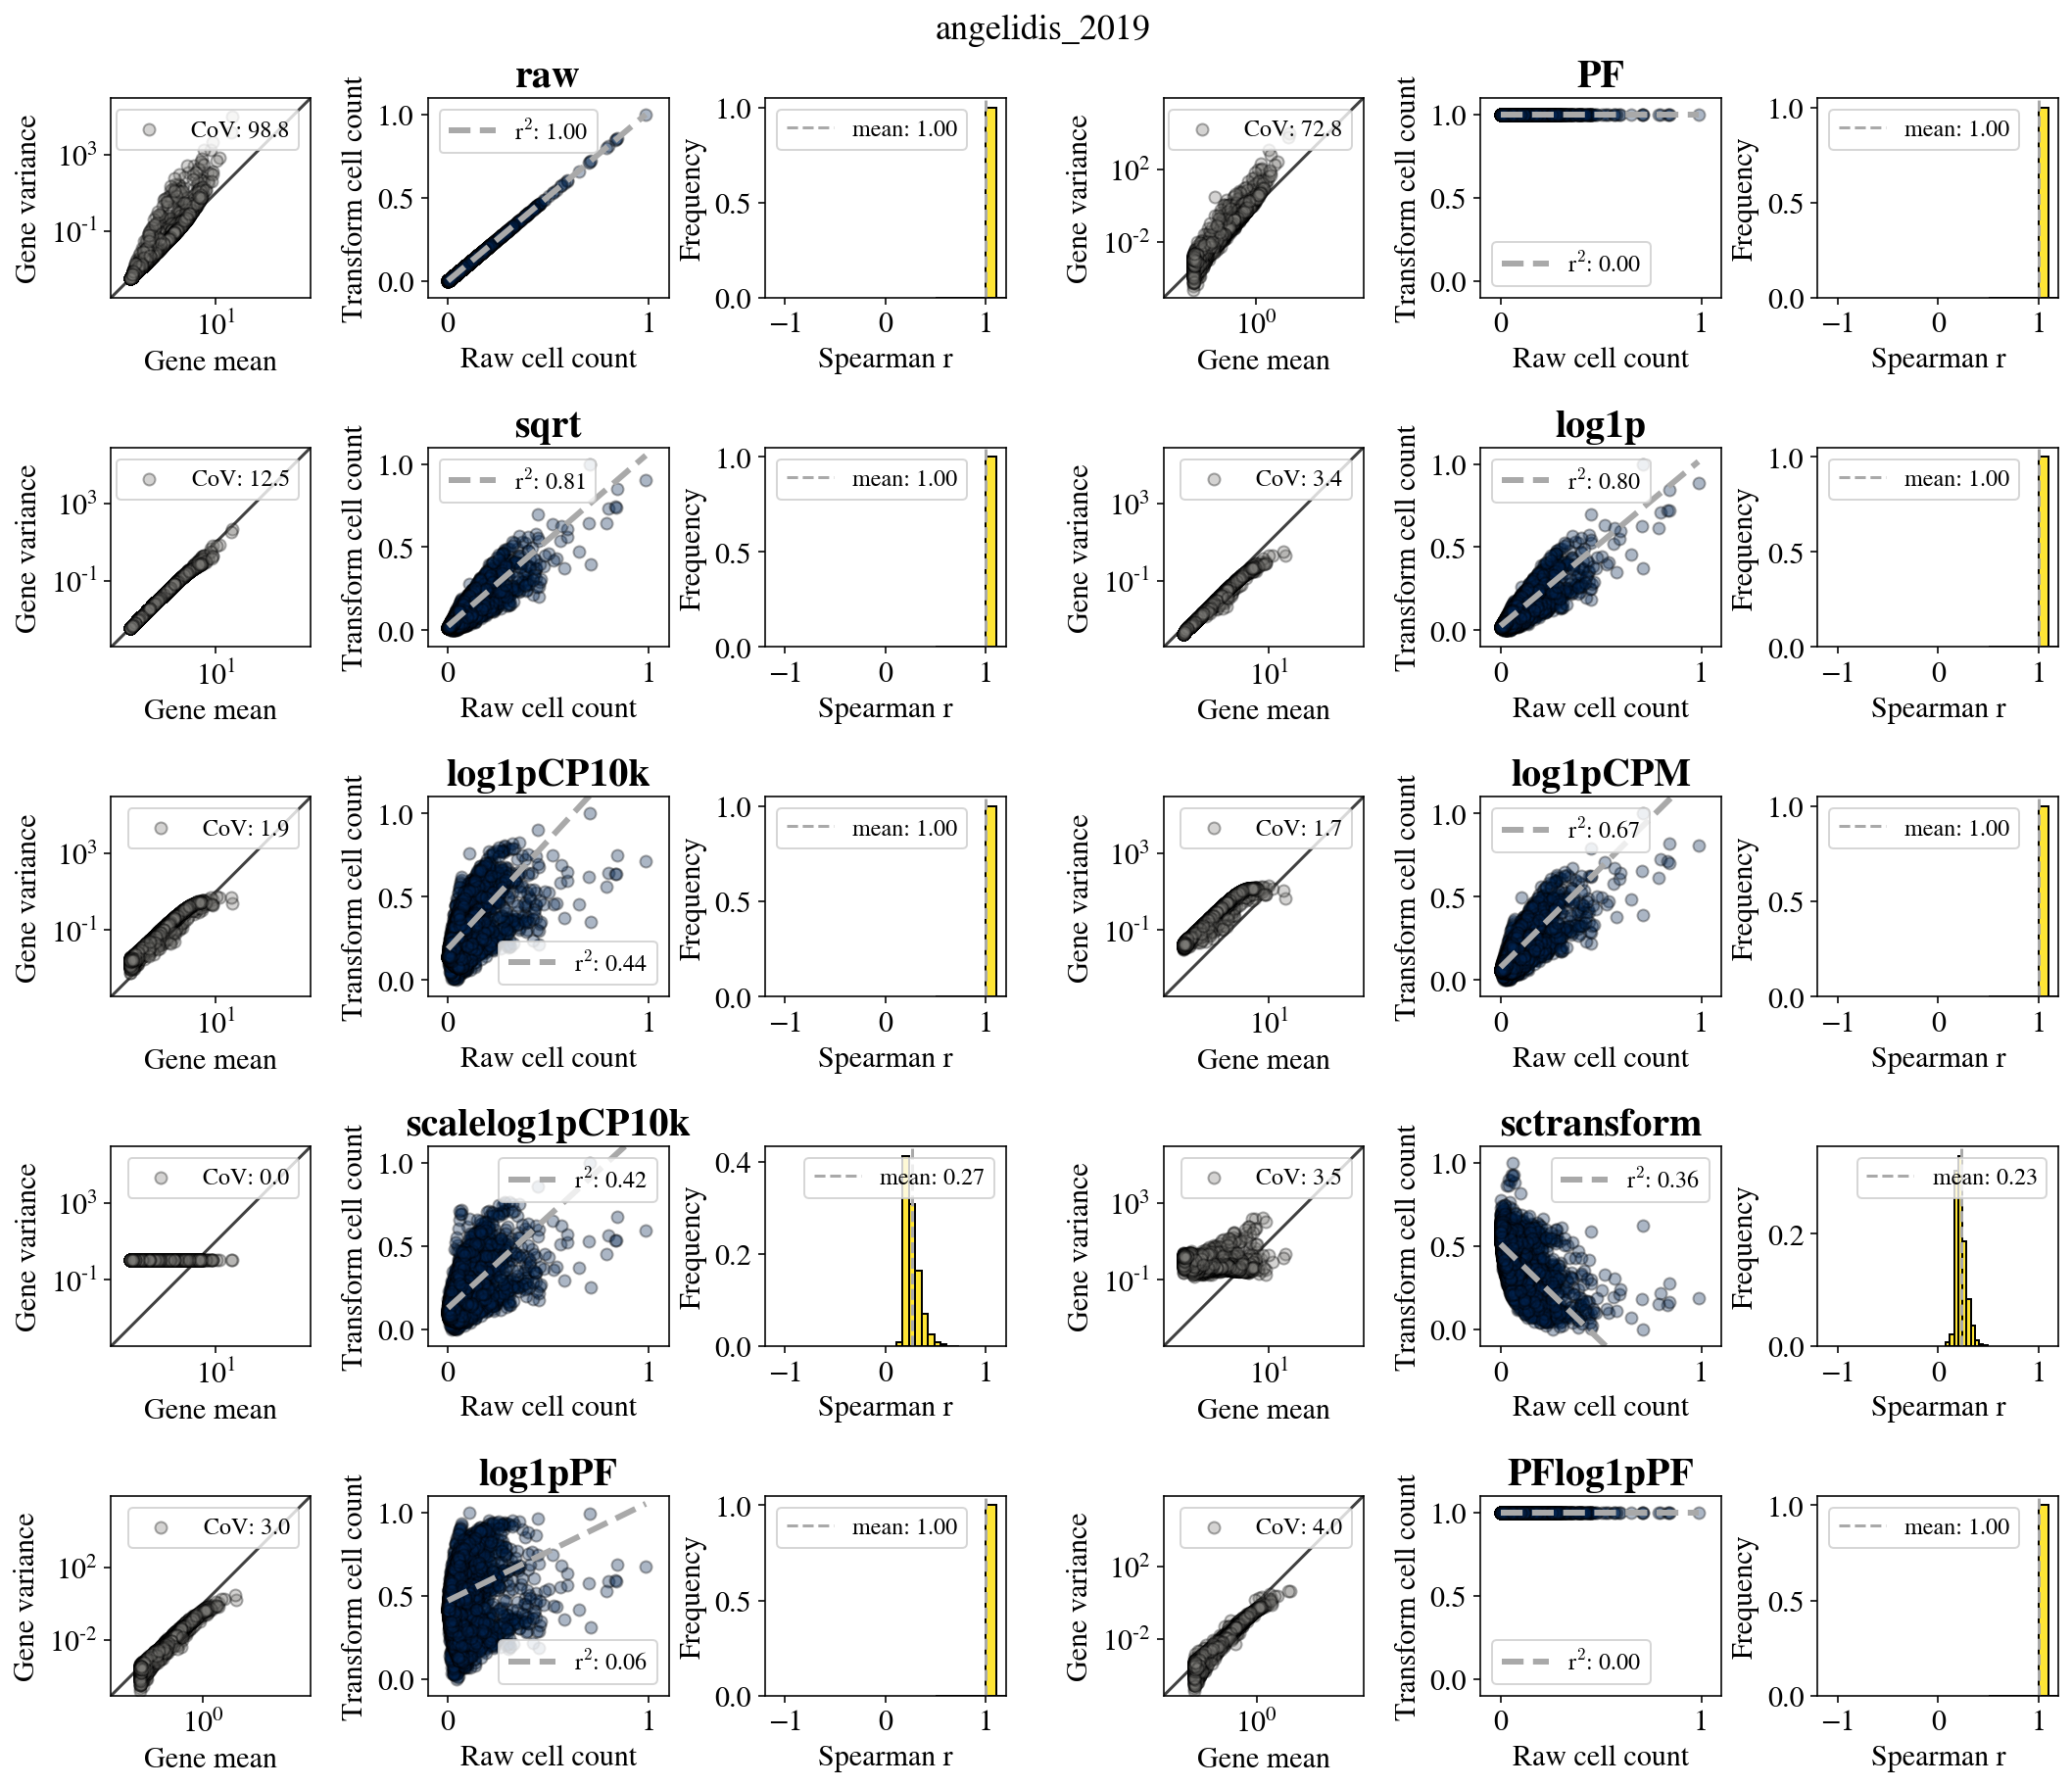

In [450]:
fig = plt.figure(figsize=(6 * 3, 5 * 3))
fig.suptitle(ds, y=0.92)
gs = gridspec.GridSpec(5, 2, figure=fig, wspace=0.15, hspace=0.75)
axs = []
for i in range(5):
    for j in range(2):
        ig = gs[i, j].subgridspec(1, 3, wspace=0.4)
        ax1 = fig.add_subplot(ig[0, 0])
        ax2 = fig.add_subplot(ig[0, 1])
        ax3 = fig.add_subplot(ig[0, 2])
        axs.append((ax1, ax2, ax3))

raw = data["raw"]

minlim = min(np.min(np.var(raw, 0)), np.min(np.mean(raw, 0))) * 0.1
maxlim = max(np.max(np.var(raw, 0)), np.max(np.mean(raw, 0))) * 10
for (ax1, ax2, ax3), title in zip(axs, labels):
    m = data[title]
    plot_meanvar(m, raw.mean(0), minlim=minlim, maxlim=maxlim, ax=ax1)
    plot_depth(m, raw.sum(1), ax2)
    plot_mono(m, raw, ax3)
    ax2.set_title(title, fontsize=20, weight="bold")

# fig.savefig(f"{ds}_methods_metrics.png", facecolor='white', transparent=False, dpi=300, bbox_inches="tight")
fig.show()

In [452]:
# metrics = {}
# for k, m in data.items():
#     print(k)
#     gvar = np.var(m, axis=0)
#     gmean = np.mean(m, axis=0)
#     cellsum = np.sum(m, axis=1)
#     depth_pearson, _ = stats.pearsonr(data["raw"].sum(1), cellsum)

#     cutoff = 0.2
#     metrics[k] = {
#         "cov_gene_var": np.sqrt(np.var(gvar)) / np.mean(gvar),
#         "cov_gene_var_mean_upper": np.sqrt(np.var(gvar[gmean >= cutoff]))
#         / np.mean(gvar[gmean >= cutoff]),
#         "cov_gene_var_mean_lower": np.sqrt(np.var(gvar[gmean < cutoff]))
#         / np.mean(gvar[gmean < cutoff]),
#         "mono": mono(m, data["raw"]).mean(),
#         "depth_pearson": depth_pearson,
#         "cov_cell_depth": np.sqrt(np.var(cellsum)) / np.mean(cellsum),
#     }

In [453]:
pd.Series(data["sctransform_cc"].sum(1)).isna().sum()

0

In [454]:
# nr = 3

# fig, axs = plt.subplots(figsize=(10, 4.5 * nr), nrows=nr)
# fig.suptitle(f"{ds}: All cells", y=0.91)
# fig.subplots_adjust(hspace=0)

# # x = ["\n".join(i.split("_")) for i in labels]
# x = labels
# xx = np.arange(len(labels))  # the label locations
# width = 0.75  # the width of the bars

# p = {"xticks": [], "xticklabels": []}

# ##################
# ax = axs[0]

# y = np.array([metrics[i]["cov_gene_var"] for i in labels])
# ax.bar(xx, y, width, label="Gene variance", edgecolor="k", color=colors["gene"])

# p.update(
#     {"ylim": 0, "yscale": "symlog", "ylabel": "Coefficient of variation gene variance"}
# )

# ax.set(**p)

# ##################
# ax = axs[1]

# y = np.array([metrics[i]["depth_pearson"] for i in labels])
# ax.bar(xx, y ** 2, width, label="Cell depth", edgecolor="k", color=colors["cell"])

# p.update({"ylabel": "Pearson $r^2$ cell depth", "yscale": "linear", "ylim": (0, 1.1)})

# ax.set(**p)


# ##################
# ax = axs[2]

# y = np.array([metrics[i]["mono"] for i in labels])
# ax.bar(
#     xx, 1 - np.abs(y), width, label="Monotonicity", edgecolor="k", color=colors["mono"]
# )

# p.update(
#     {
#         "yscale": "linear",
#         "xticks": xx,
#         "ylim": (0, 1.1),
#         "ylabel": "1 - | Spearman r$^2$ cell transform |",
#     }
# )
# ax.set(**p)
# ax.set_xticklabels(x, ha="right", rotation=45)

# base_file_name = "angelidis_2019_metrics-bar"
# save_path = os.path.join(base_figure_path, base_file_name)
# if not os.path.exists(save_path):
#     os.makedirs(save_path)

# fig.savefig(
#     os.path.join(save_path, f"{base_file_name}.png"),
#     facecolor="white",
#     transparent=False,
#     dpi=300,
#     bbox_inches="tight",
# )
# fig.savefig(
#     os.path.join(save_path, f"{base_file_name}.pdf"), dpi=300, bbox_inches="tight"
# )

# fig.show()

# Celltype Metrics

In [455]:
pd.DataFrame({"cellsum": data["raw"].sum(1), "celltype": assignments}).groupby(
    "celltype"
).agg({"cellsum": ["var", "count", "sum", "mean"]})["cellsum"].sort_values(
    ["count"], ascending=False
)

,var,count,sum,mean
celltype,,,,
Type_2_pneumocytes,3.808068e+05,4199,3717832,885.408907
Alveolar_macrophage,2.463729e+05,1704,1185836,695.913146
Ciliated_cells,1.227495e+06,883,887542,1005.143828
B_cells,2.415417e+05,855,496537,580.745029
Club_cells,2.957619e+06,772,1221242,1581.919689
vascular_endothelial_cells,5.747923e+04,631,279089,442.296355
CD8+_T_cells,2.166643e+05,612,389606,636.611111
Cd4+_T_cells,1.352873e+05,591,336177,568.827411
low_quality_cells,3.294878e+04,495,214193,432.713131


In [9]:
celltypes = ["Type_2_pneumocytes", "Alveolar_macrophage", "Ciliated_cells"]
ct_masks = [assignments == i for i in celltypes]
ct = celltypes[0]
ct_mask = ct_masks[0]

In [10]:
ct

'Type_2_pneumocytes'

In [11]:
met_var = {'raw': {'pc_entropy': 5.976929973592573},
             'PF': {'pc_entropy': 5.3669956608835845},
             'sqrt': {'pc_entropy': 8.360781912110472},
             'log1p': {'pc_entropy': 8.42779545156364},
             'log1pCP10k': {'pc_entropy': 8.583779951129223},
             'log1pCPM': {'pc_entropy': 8.683813337301101},
             'scalelog1pCP10k': {'pc_entropy': 9.168871956866903},
             'sctransform': {'pc_entropy': 9.316958262806056},
             'log1pPF': {'pc_entropy': 8.236090687865959},
             'PFlog1pPF': {'pc_entropy': 8.163219894497587}}
met_depth = {'raw': {'depth_distance': 0.8879854960414477,
              'de_genes': 2397,
              'r2_pc1': 0.8993352027935686},
             'PF': {'depth_distance': -0.05591480391599708,
              'de_genes': 16,
              'r2_pc1': 0.07820314771925342},
             'sqrt': {'depth_distance': 0.7643776690137498,
              'de_genes': 2412,
              'r2_pc1': 0.9153759529116909},
             'log1p': {'depth_distance': 0.7600414825050223,
              'de_genes': 2410,
              'r2_pc1': 0.9465309112166684},
             'log1pCP10k': {'depth_distance': 0.6458577872213163,
              'de_genes': 1490,
              'r2_pc1': 0.78569150398444},
             'log1pCPM': {'depth_distance': 0.7051055526292076,
              'de_genes': 2228,
              'r2_pc1': 0.9092972342294078},
             'scalelog1pCP10k': {'depth_distance': 0.6065288648407331,
              'de_genes': 1490,
              'r2_pc1': 0.8424593677240342},
             'sctransform': {'depth_distance': 0.8332989281973592,
              'de_genes': 442,
              'r2_pc1': 0.09837301805762556},
             'log1pPF': {'depth_distance': 0.3896057686644336,
              'de_genes': 210,
              'r2_pc1': 0.1855903169112012},
             'PFlog1pPF': {'depth_distance': 0.01878578964798529,
              'de_genes': 22,
              'r2_pc1': 0.00025028874600219186}}
met_mono = {'raw': {'ct_spearman': 0.9070958231156043},
             'PF': {'ct_spearman': 0.9052128799188046},
             'sqrt': {'ct_spearman': 0.9047463672545093},
             'log1p': {'ct_spearman': 0.9054433106185621},
             'log1pCP10k': {'ct_spearman': 0.9035664692740538},
             'log1pCPM': {'ct_spearman': 0.9070319009110377},
             'scalelog1pCP10k': {'ct_spearman': 0.7956653520897112},
             'sctransform': {'ct_spearman': 0.8100201956906367},
             'log1pPF': {'ct_spearman': 0.9033501861824151},
             'PFlog1pPF': {'ct_spearman': 0.9054226138531041}}

In [12]:
mets = defaultdict(dict)
for l in labels:
    mets[l].update(met_var[l])
    mets[l].update(met_depth[l])
    mets[l].update(met_mono[l])

In [13]:
mets["raw"]

{'pc_entropy': 5.976929973592573,
 'depth_distance': 0.8879854960414477,
 'de_genes': 2397,
 'r2_pc1': 0.8993352027935686,
 'ct_spearman': 0.9070958231156043}

## cp10k_log_scale v sctransform

In [271]:
def corr2_coeff(A, B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:, None]
    B_mB = B - B.mean(1)[:, None]

    # Sum of squares across rows
    ssA = (A_mA ** 2).sum(1)
    ssB = (B_mB ** 2).sum(1)

    # Finally get corr coeff
    return np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None], ssB[None]))

In [272]:
pr = defaultdict()
for c, c_mask in zip(celltypes, ct_masks):
    pr[c] = np.diagonal(
        corr2_coeff(data["scalelog1pCP10k"][c_mask], data["sctransform"][c_mask])
    )

In [273]:
spr = defaultdict()
for c, c_mask in zip(celltypes, ct_masks):
    spr[c] = np.diagonal(
        corr2_coeff(
            stats.rankdata(data["scalelog1pCP10k"][c_mask], axis=1),
            stats.rankdata(data["sctransform"][c_mask], axis=1),
        )
    )

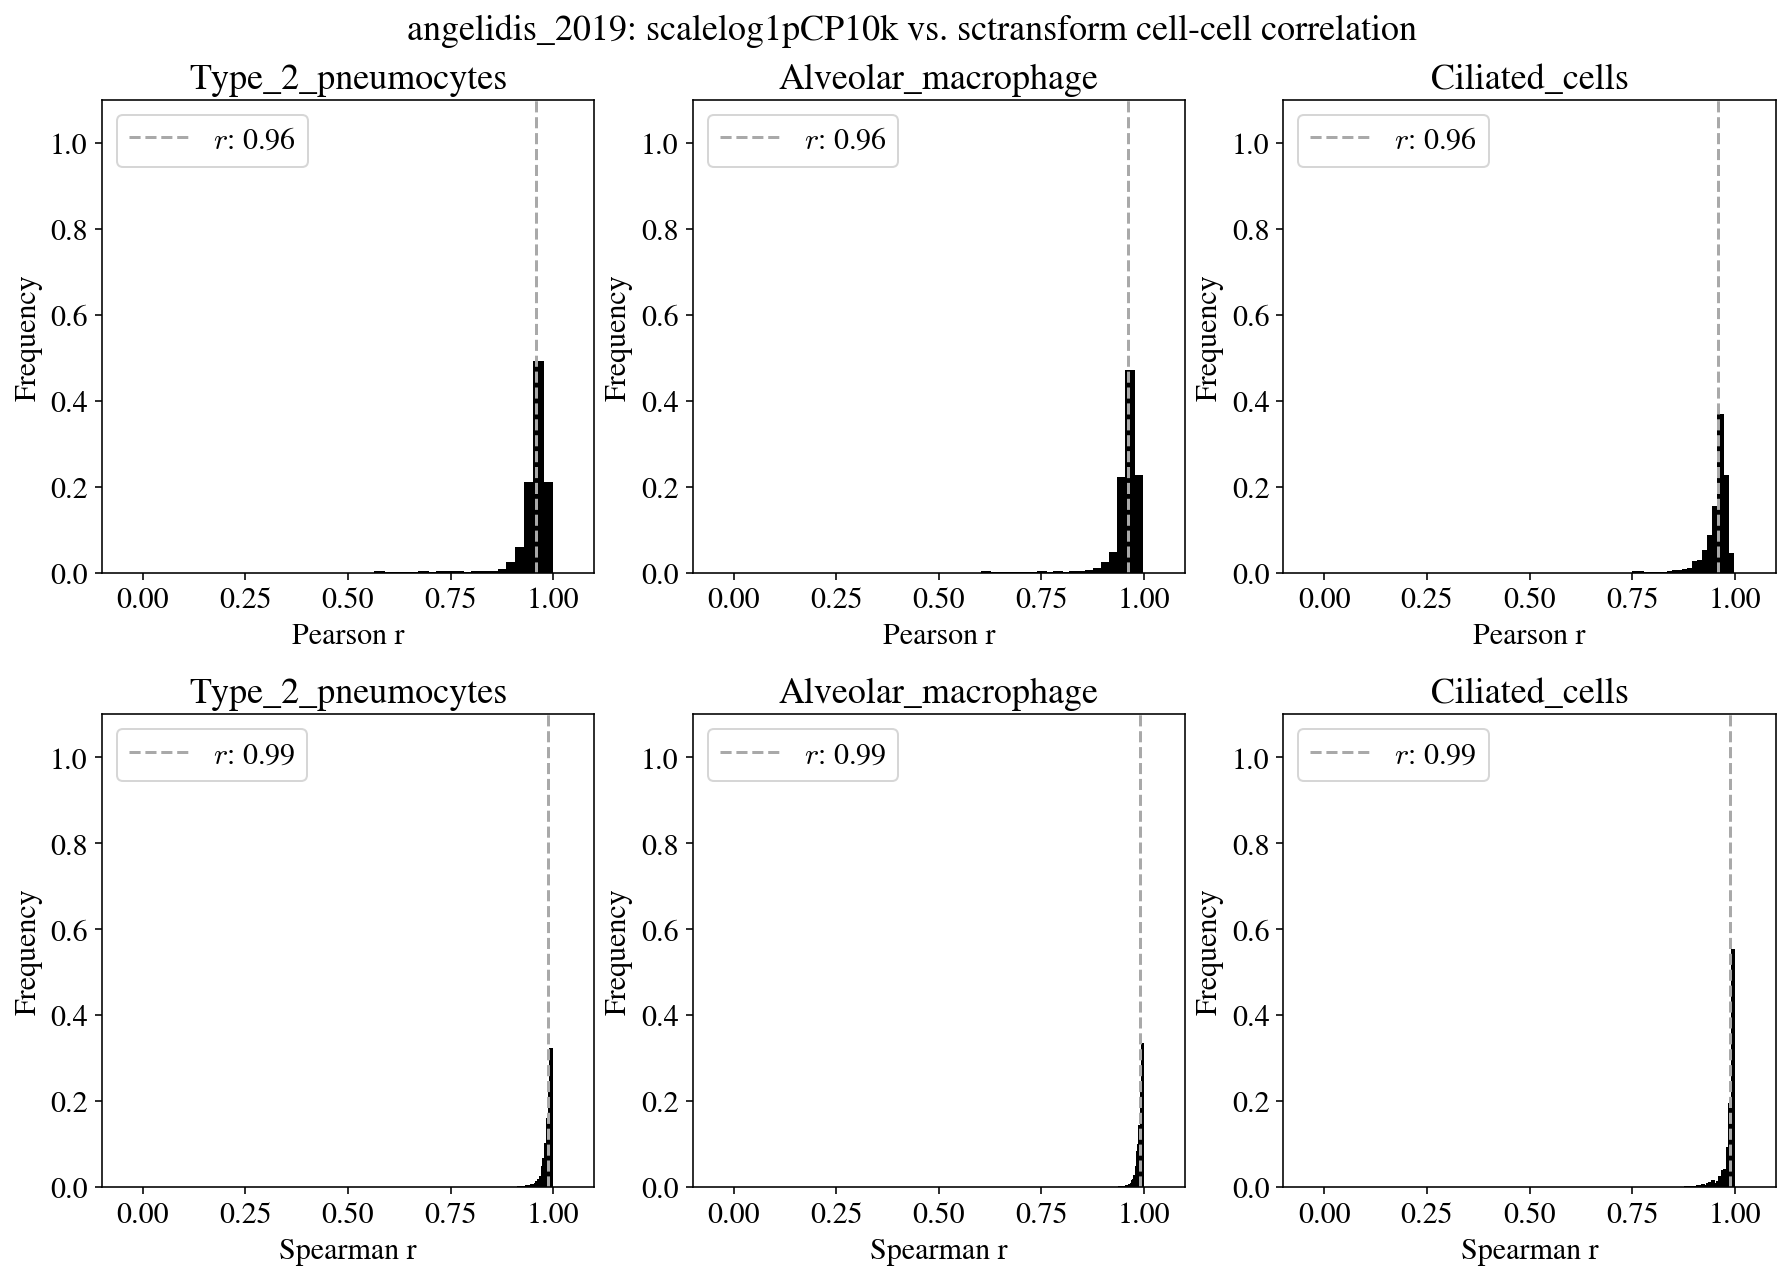

In [275]:
nr, nc = 2, 3
fig, axs = plt.subplots(figsize=(5 * nc, 5 * nr), ncols=nc, nrows=nr)
fig.suptitle(f"{ds}: scalelog1pCP10k vs. sctransform cell-cell correlation", y=0.94)
fig.subplots_adjust(hspace=0.3)
p = {"xlim": (-0.1, 1.1)}


for idx, c in enumerate(celltypes):
    ax = axs[0, idx]

    x = pr[c]

    weights = np.ones(len(x)) / len(x)
    ax.hist(x, weights=weights, facecolor="k", edgecolor="k", bins=20)
    ax.axvline(
        x.mean(), label=f"$r$: {x.mean():,.2f}", linestyle="--", color="darkgray"
    )
    ax.set(
        **{
            "xlim": (-0.1, 1.1),
            "ylim": (0, 1.1),
            "title": c,
            "xlabel": "Pearson r",
            "ylabel": "Frequency",
        }
    )
    ax.legend()

for idx, c in enumerate(celltypes):
    ax = axs[1, idx]
    p.update({"title": f"{c}"})

    x = spr[c]

    weights = np.ones(len(x)) / len(x)
    ax.hist(x, weights=weights, facecolor="k", edgecolor="k", bins=20)
    ax.axvline(
        x.mean(), label=f"$r$: {x.mean():,.2f}", linestyle="--", color="darkgray"
    )
    ax.set(
        **{
            "xlim": (-0.1, 1.1),
            "ylim": (0, 1.1),
            "title": c,
            "xlabel": "Spearman r",
            "ylabel": "Frequency",
        }
    )

    ax.legend()

base_file_name = (
    "angelidis_2019-scalelog1pCP10k_sctransform_pearson_spearman_celltype-hist"
)
save_path = os.path.join(base_figure_path, base_file_name)
if not os.path.exists(save_path):
    os.makedirs(save_path)

fig.savefig(
    os.path.join(save_path, f"{base_file_name}.png"),
    facecolor="white",
    transparent=False,
    dpi=300,
    bbox_inches="tight",
)
fig.savefig(
    os.path.join(save_path, f"{base_file_name}.pdf"), dpi=300, bbox_inches="tight"
)

fig.show()

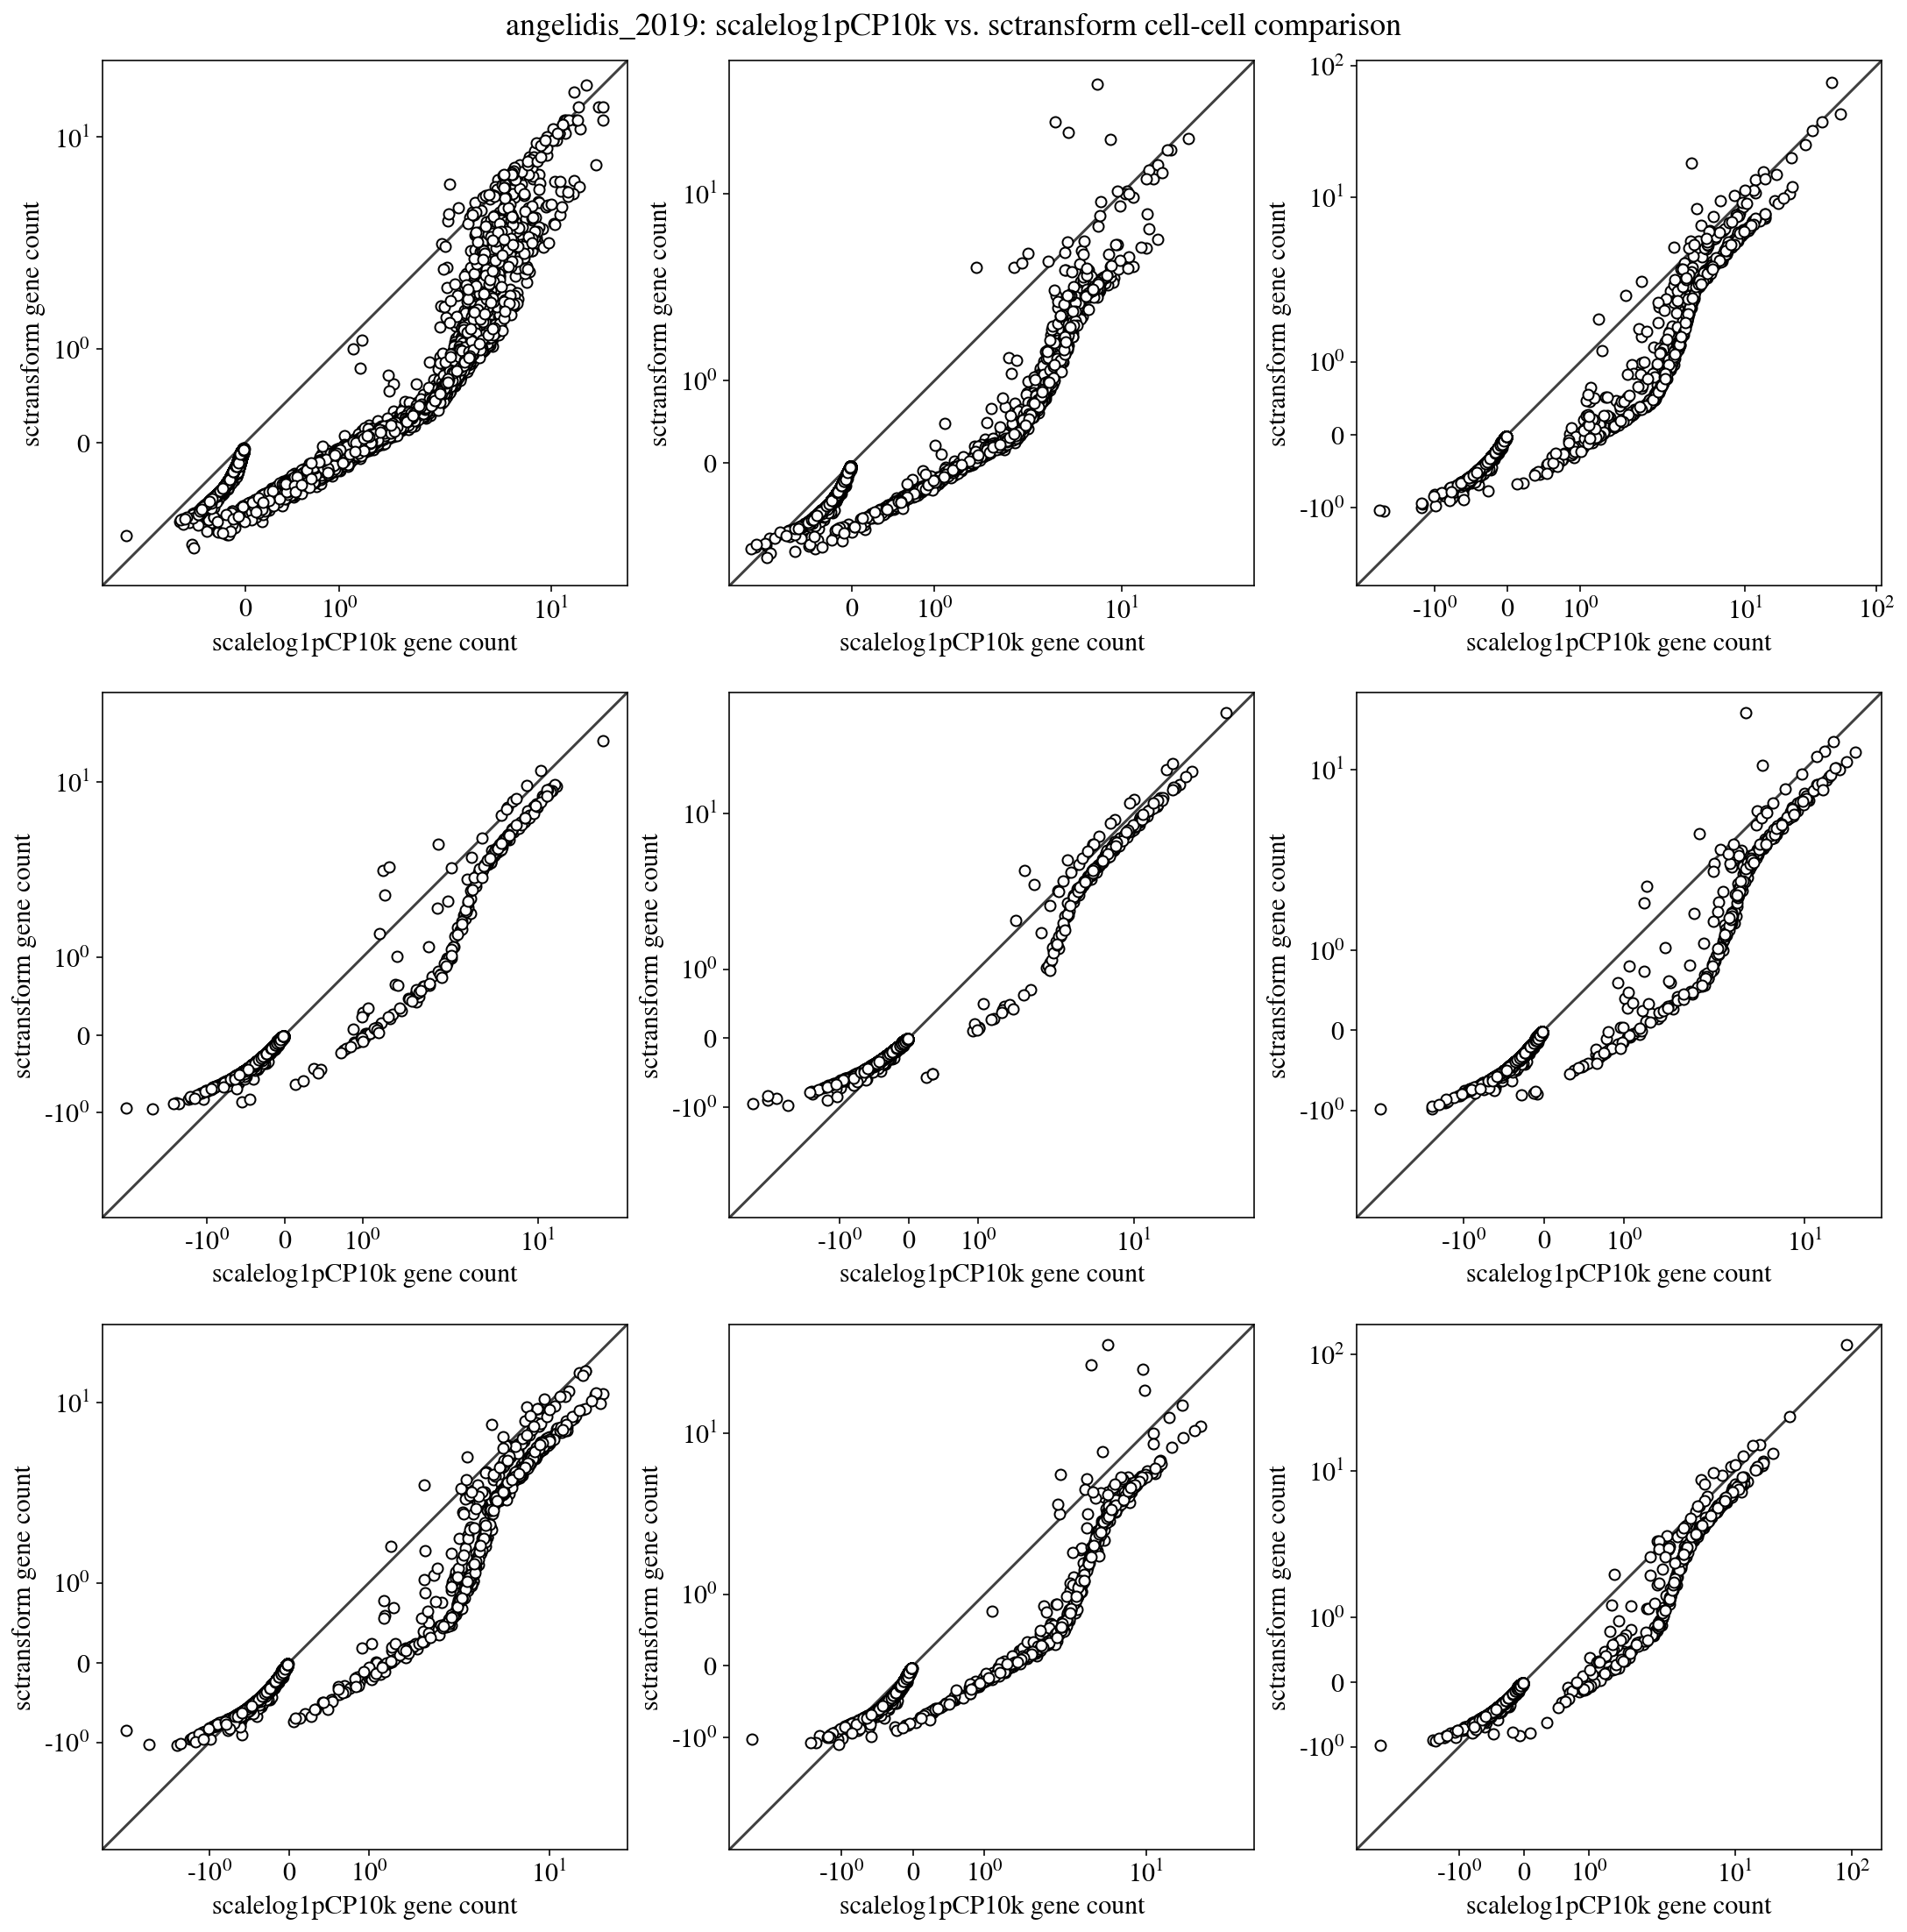

In [276]:
n = 3
fig, axs = plt.subplots(
    figsize=(5 * n, 5 * n), ncols=n, nrows=n, constrained_layout=True
)
fig.suptitle(f"{ds}: scalelog1pCP10k vs. sctransform cell-cell comparison", y=1.01)

for idx, ax in enumerate(fig.axes):
    x = data["scalelog1pCP10k"][-idx]
    y = data["sctransform"][-idx]
    ax.scatter(x, y, facecolor="white", edgecolor="k")

    ax.set(
        **{
            "xlabel": "scalelog1pCP10k gene count",
            "ylabel": "sctransform gene count",
            "xscale": "symlog",
            "yscale": "symlog",
        }
    )
    yex(ax)


base_file_name = (
    "angelidis_2019-_scalelog1pCP10k_sctransform_pearson_spearman_examples-scatter"
)
save_path = os.path.join(base_figure_path, base_file_name)
if not os.path.exists(save_path):
    os.makedirs(save_path)

fig.savefig(
    os.path.join(save_path, f"{base_file_name}.png"),
    facecolor="white",
    transparent=False,
    dpi=300,
    bbox_inches="tight",
)
fig.savefig(
    os.path.join(save_path, f"{base_file_name}.pdf"), dpi=300, bbox_inches="tight"
)

fig.show()

# Celltype specific figure

In [16]:
# for k, v in data.items():
#     # pairwise spearman then the mean of that
#     ct_metrics[k]["mono"] = np.diagonal(
#         corr2_coeff(
#             stats.rankdata(v[ct_mask], axis=1),
#             stats.rankdata(data["raw"][ct_mask], axis=1),
#         )
#     ).mean()

In [17]:
mets["raw"].keys()

dict_keys(['pc_entropy', 'depth_distance', 'de_genes', 'r2_pc1', 'ct_spearman'])

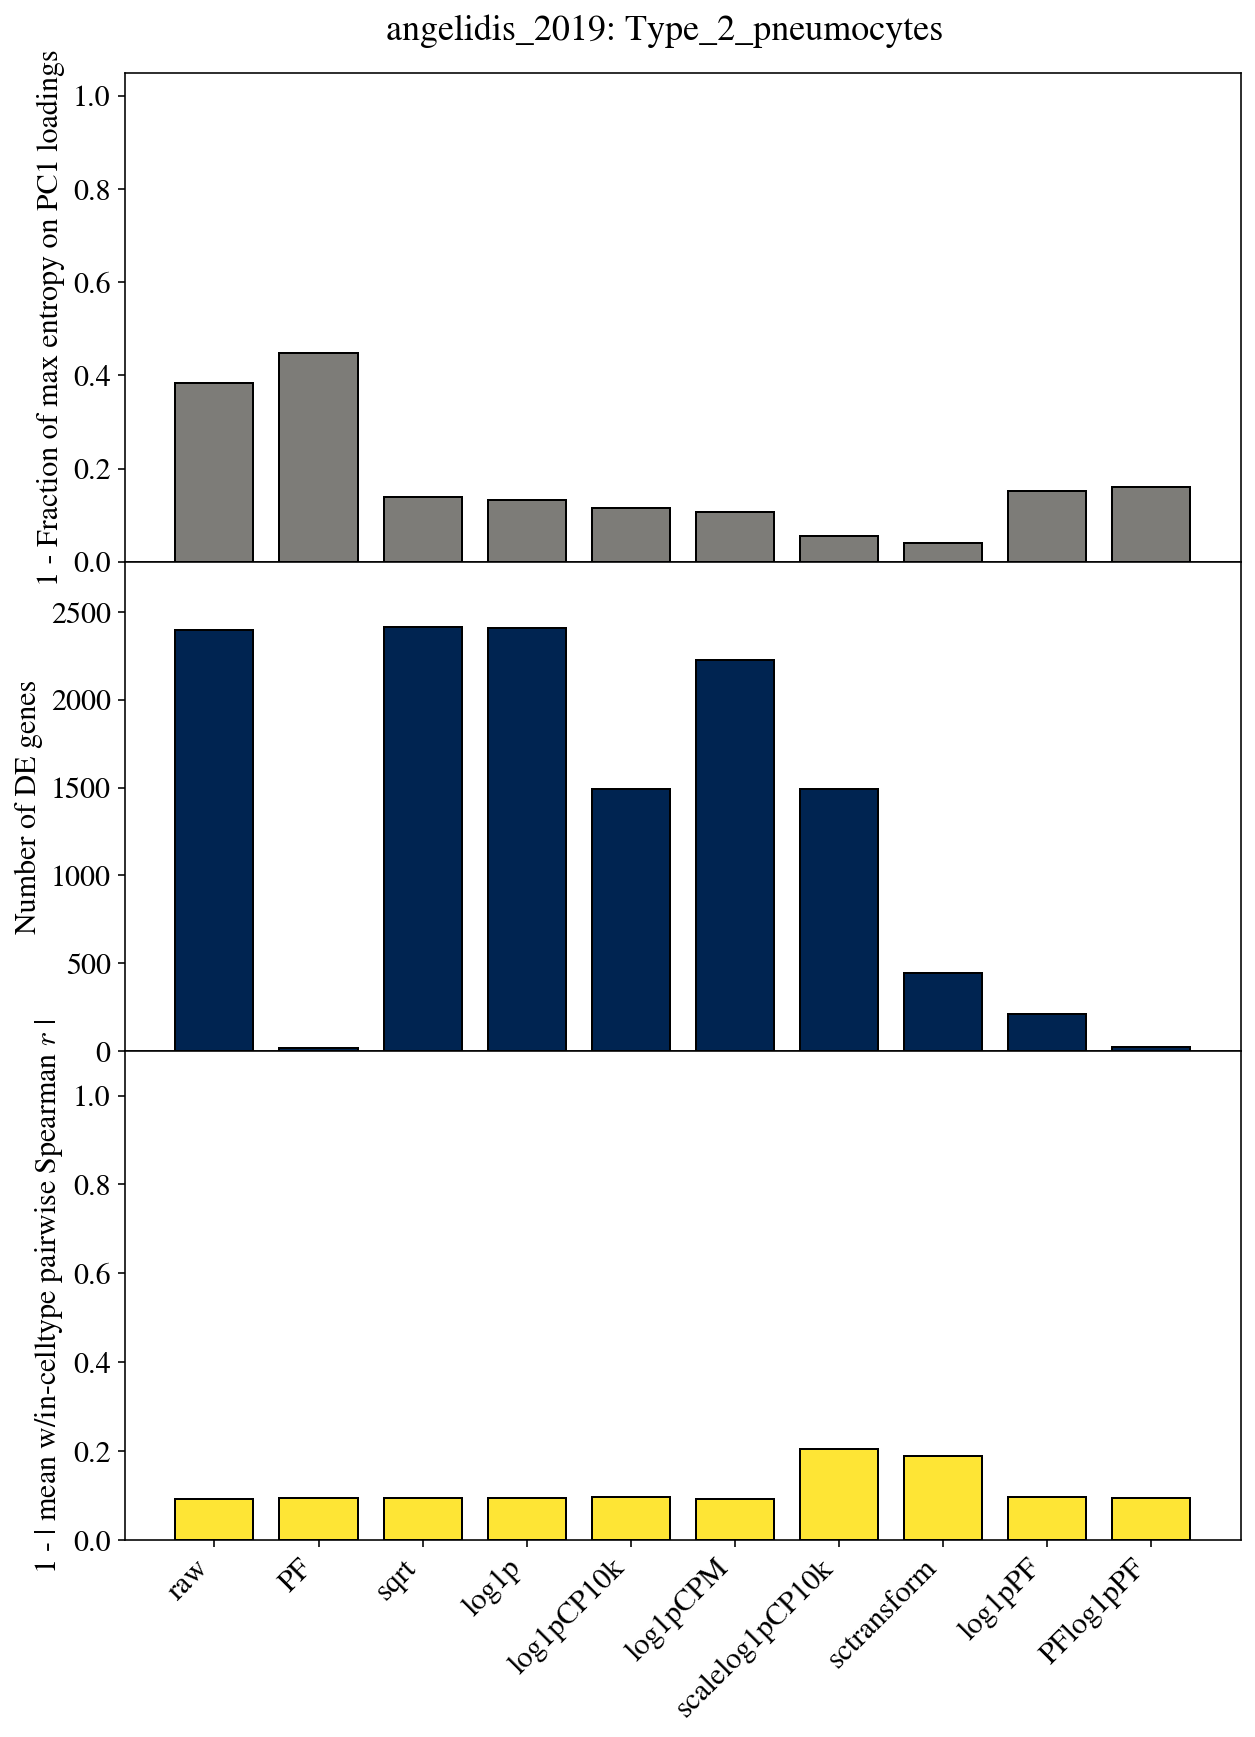

In [24]:
nr = 3

fig, axs = plt.subplots(figsize=(10, 4.5 * nr), nrows=nr)
fig.suptitle(f"{ds}: {ct}", y=0.91)
fig.subplots_adjust(hspace=0)

# x = ["\n".join(i.split("_")) for i in labels]
x = labels
xx = np.arange(len(labels))  # the label locations
width = 0.75  # the width of the bars

p = {"xticks": [], "xticklabels": []}

##################
ax = axs[0]

maxent = -np.log(1 / data["raw"].shape[1])

y = np.array([mets[i]["pc_entropy"] for i in labels])
ax.bar(
    xx,
    (maxent - y) / maxent,
    width,
    label="PC entropy",
    edgecolor="k",
    color=colors["gene"],
)

p.update({"ylim": (0, 1.05), "ylabel": "1 - Fraction of max entropy on PC1 loadings"})

ax.set(**p)

##################
ax = axs[1]

y = np.array([mets[i]["de_genes"] for i in labels])
ax.bar(
    xx, y, width, label="False positive DE genes", edgecolor="k", color=colors["cell"]
)

p.update(
    {
        "ylim": (0, ax.get_ylim()[1] * 1.1),
        "ylabel": "Number of DE genes",
    }
)

ax.set(**p)


##################
ax = axs[2]

maxsp = np.abs(mets["raw"]["ct_spearman"])
y = np.abs(np.array([mets[i]["ct_spearman"] for i in labels]))
ax.bar(xx, 1 - y, width, label="pairwise_sp", edgecolor="k", color=colors["mono"])
# ax.bar(xx, 1-y/maxsp, width, label="pairwise_sp", edgecolor="k", color=colors["mono"])

p.update(
    {
        "yscale": "linear",
        "xticks": xx,
        "ylim": (0, 1.1),
        "ylabel": "1 - | mean w/in-celltype pairwise Spearman $r$ |",
#         "ylabel": "1 - fraction of max \n| mean w/in-celltype pairwise Spearman $r$ |",
    }
)
ax.set(**p)
ax.set_xticklabels(x, ha="right", rotation=45)

base_file_name = "angelidis_2019-celltype_metrics_pc_de_mono-bar"
save_path = os.path.join(base_figure_path, base_file_name)
if not os.path.exists(save_path):
    os.makedirs(save_path)

fig.savefig(
    os.path.join(save_path, f"{base_file_name}.png"),
    facecolor="white",
    transparent=False,
    dpi=300,
    bbox_inches="tight",
)
fig.savefig(
    os.path.join(save_path, f"{base_file_name}.pdf"), dpi=300, bbox_inches="tight"
)

fig.show()

/home/sina/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator


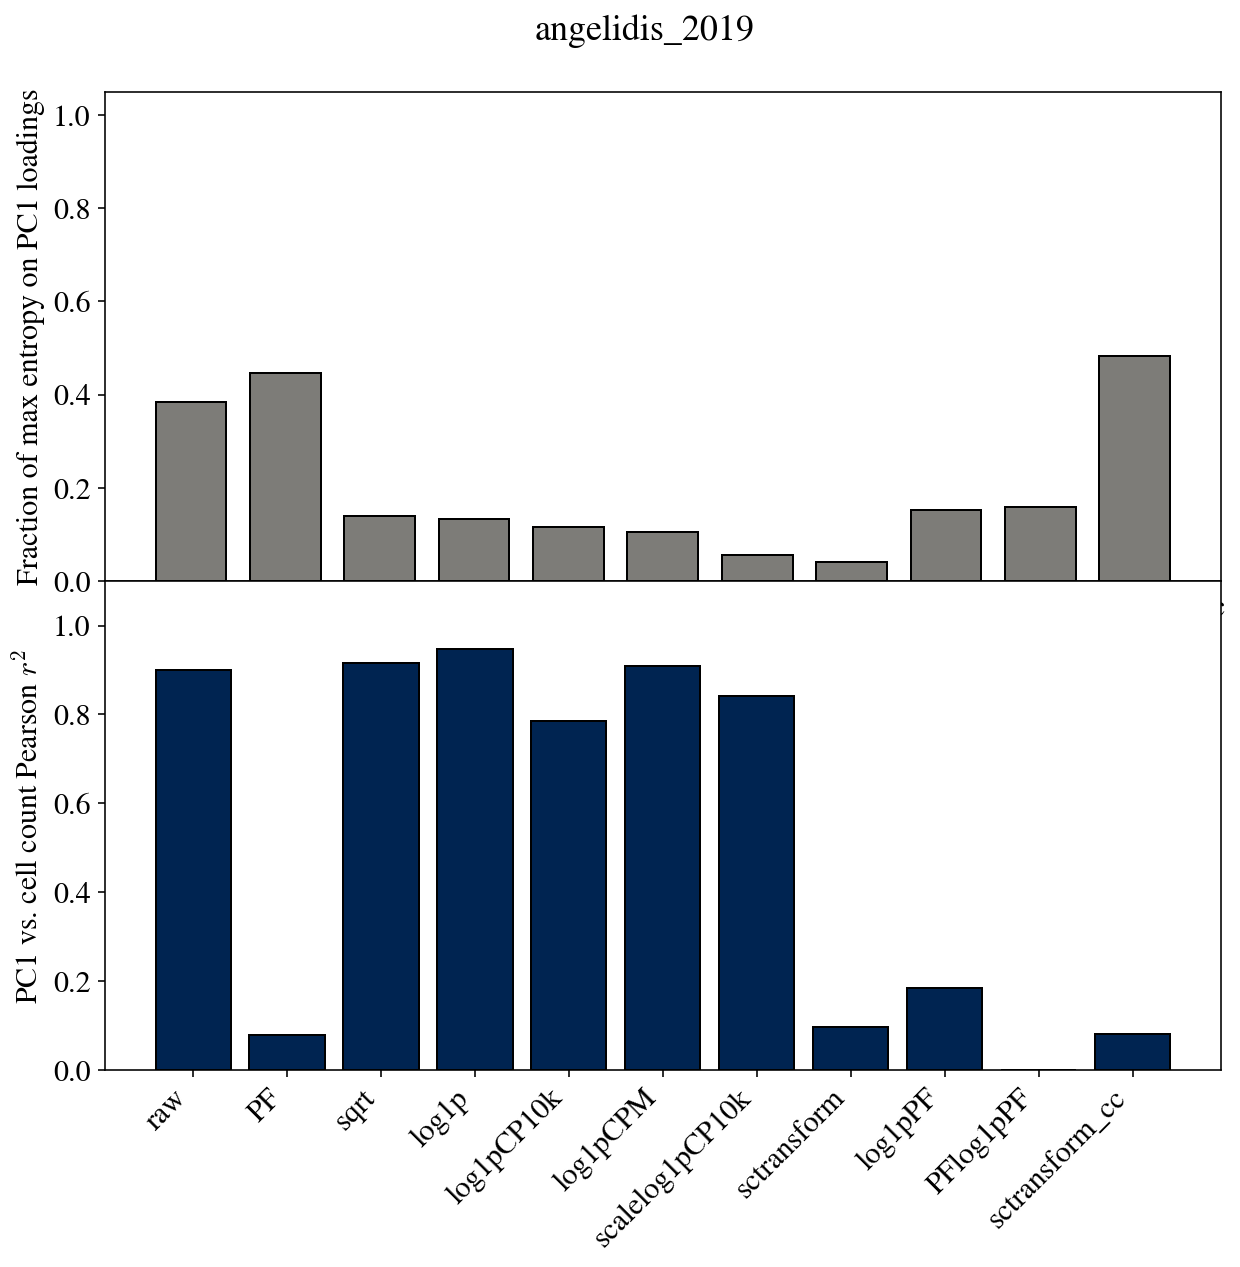

In [331]:
fig, axs = plt.subplots(figsize=(10, 4.5 * 2), nrows=2)
fig.suptitle(ds, y=0.94)
fig.subplots_adjust(hspace=0)

ax = axs[0]


x = [k for k, _ in pc_corr.items()]

maxent = -np.log(1 / data["raw"].shape[1])

y = np.array([ct_metrics[i]["pc_entropy"] for i in x])
ax.bar(
    x,
    (maxent - y) / maxent,
    width,
    label="PC entropy",
    edgecolor="k",
    color=colors["gene"],
)

p.update()

ax.set(**{"ylim": (0, 1.05), "ylabel": "1 - Fraction of max entropy on PC1 loadings"})

##################
ax = axs[1]


y = np.array([v for k, v in pc_corr.items()])
ax.bar(x, y ** 2, facecolor=colors["cell"], edgecolor="k")
ax.set(**{"ylabel": "PC1 vs. cell count Pearson $r^2$", "ylim": (0, 1.1)})

ax.set_xticklabels(x, ha="right", rotation=45)

# fig.savefig(f"{ds}_dim_reduce.png", facecolor='white', transparent=False, dpi=300, bbox_inches="tight")

fig.show()

# Cell depth per cell type

In [336]:
pd.Series(assignments).nunique()

33

In [395]:
def p0(m, phi=0.1):
    return (phi ** -1 / (m + phi ** -1)) ** (phi ** -1)

In [430]:
p0(0)

1.0

In [425]:
a = mmread("synchromesh/data/angelidis_2019/sparse/raw.mtx.gz")

In [427]:
x

matrix([[4.72557888e-04, 1.96449065e-02, 3.93573213e-02, ...,
         6.75082698e-05, 6.75082698e-05, 6.75082698e-05]])

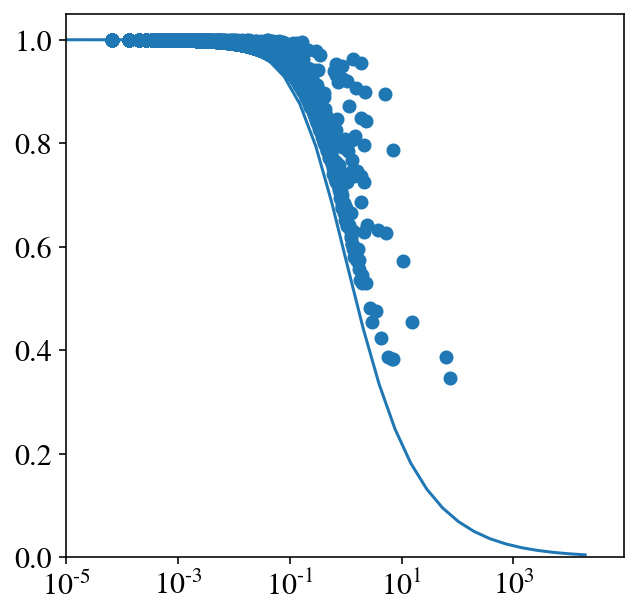

In [445]:
fig, ax = plt.subplots(figsize=(5, 5))

x = a.mean(0).A.ravel()
y = (a > 0).sum(0).A.ravel() / a.shape[1]

ax.scatter(x, 1 - y)

# xx = np.linspace(x.min(), x.max()*10)
xx = np.logspace(np.log(x[x > 0].min()), np.log(x[x > 0].max()))
ax.plot(xx, p0(xx, phi=2))

ax.set(**{"xscale": "log", "ylim": (0, 1.05), "xlim": (1e-5)})

fig.show()

In [440]:
np.log(x[x > 0].min())

-9.603260452582052

In [419]:
xx

array([1.00077752e+00, 3.00647603e+01, 9.03187566e+02, 2.71330212e+04,
       8.15114012e+05, 2.44871681e+07, 7.35628875e+08, 2.20993231e+10,
       6.63894662e+11, 1.99443268e+13, 5.99155548e+14, 1.79994730e+16,
       5.40729414e+17, 1.62442700e+19, 4.88000653e+20, 1.46602240e+22,
       4.40413691e+23, 1.32306450e+25, 3.97467131e+26, 1.19404701e+28,
       3.58708468e+29, 1.07761055e+31, 3.23729322e+32, 9.72528288e+33,
       2.92161138e+35, 8.77693034e+36, 2.63671297e+38, 7.92105557e+39,
       2.37959619e+41, 7.14864069e+42, 2.14755193e+44, 6.45154718e+45,
       1.93813526e+47, 5.82243014e+48, 1.74913968e+50, 5.25466091e+51,
       1.57857383e+53, 4.74225719e+54, 1.42464057e+56, 4.27982009e+57,
       1.28571798e+59, 3.86247714e+60, 1.16034230e+62, 3.48583102e+63,
       1.04719253e+65, 3.14591323e+66, 9.45076455e+67, 2.83914222e+69,
       8.52918143e+70, 2.56228572e+72])